# DGA Detection Model

## Table of Contents
* Introduction
* Dataset
* Data Preprocessing
* Binary Model Training and Evaluation
* Familieis Model Training and Evaluation
* Conclusions
* References

## Introduction

Domain generation algorithms (DGA) are algorithms seen in various families of malware that are used to periodically generate a large number of domain names that can be used as rendezvous points with their command and control servers. The large number of potential rendezvous points makes it difficult for law enforcement to effectively shut down botnets, since infected computers will attempt to contact some of these domain names every day to receive updates or commands. The use of public-key cryptography in malware code makes it unfeasible for law enforcement and other actors to mimic commands from the malware controllers as some worms will automatically reject any updates not signed by the malware controllers.

In this work we run two variants of DGA models on public dataset of DGA, binary DGA and families DGA.

## Dataset

We gathered 3M domains from popular datasets of DGAs.
i.e. https://data.netlab.360.com/dga/

### Requirements

In [1]:
# Install dependencies
#!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import LabelEncoder
import swifter
import tldextract

import torch
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Parameters and variables

Here we define set of global parameters and fixed variables for training the two variants of DGA model.

In [15]:
# Binary model params
EPOCHS = 30
BATCH_SIZE = 1000
MALICIOUS_RATIO = 0.01
LEARNING_RATE = 0.001

# Families model params
TRAIN_BATCH_SIZE = 500
TEST_BATCH_SIZE = 500
EMB_SIZE = 10
EPOCHS_SIAMESE = 120
LEARNING_RATE_SIAMESE = 1e-3
CLASS_WEIGHTS = {0: 100, 1:1}
# Triplet loss
alpha = 1.5  #value between 0-2

### Utility methods

In [16]:
# Return URL domain
def get_domain(url):
    domain = tldextract.extract(url).domain
    if domain == 'ddns':
        print(url)
        urls = url.split('.')
        urls_i = urls.index('ddns')
        if urls_i == 0:
            return 'ddns'
        print(urls[urls_i-1])
        return urls[urls_i-1]
    if domain:
        return domain
    return ''
# Make spaces for character processing
def get_domain_space(domain):
    try:
        return " ".join(domain)
    except:
        print(domain)
        return ""
# Split train-test - we are trying change the ratio for small DGA families to test them too 
def split_train_test_dga(df,ratio=0.8):
    df_dga = df[df['label']==1]
    df_legit = df[df['label']==0]
    X_dga, y_dga = df_dga['domain_1'],df_dga['label']
    X_legit, y_legit = df_legit['domain_1'],df_legit['label']
    train_dga_i = []
    train_ben_i = []
    test_dga_i = []
    test_ben_i = []
    # Make the dga train set to be more equale between families without dominant family
    for fam in pd.unique(df_dga['type']):
        df_dga_fam = df_dga[df_dga['type']==fam]
        # Shuffle the dataframe rows
        df_dga_fam = df_dga_fam.sample(frac = 1)
        if len(df_dga_fam)>10000:
            train_dga_i.extend(df_dga_fam.iloc[0:int(ratio*10000)].index)
            test_dga_i.extend(df_dga_fam.iloc[int(ratio*10000):].index)
        else:
            train_dga_i.extend(df_dga_fam.iloc[0:int(ratio*len(df_dga_fam))].index)
            test_dga_i.extend(df_dga_fam.iloc[int(ratio*len(df_dga_fam)):].index)
    df_legit = df_legit.sample(frac = 1)
    train_ben_i.extend(df_legit.iloc[0:int(ratio*len(df_legit))].index)
    test_ben_i.extend(df_legit.iloc[int(ratio*len(df_legit)):].index)
    train_dga_i.extend(train_ben_i)
    test_dga_i.extend(test_ben_i)
    X_train = df['domain_1'][train_dga_i]
    y_train = df['label'][train_dga_i]
    X_test = df['domain_1'][test_dga_i]
    y_test = df['label'][test_dga_i]
    
    return X_train, X_test, y_train, y_test
# Create data loader for the neural-net
def create_data_loader(data,label):
    tensor_data = torch.Tensor(data.astype(int))
    tensor_label = torch.Tensor(label)
    my_dataset = TensorDataset(tensor_data,tensor_label)
    data_loader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return data_loader
# Create batches for Siamese networks
def create_batch_offline(indices,batch_size,anc_indices,domain_indices=None):
    """choose an anchor, a positive and a negative batch.
    if domain_indices is given, choose anchor only from the specified domains indices. """
    x_anchors = np.zeros((batch_size, 75))
    x_positives = np.zeros_like(x_anchors)
    x_negatives = np.zeros_like(x_anchors)

    y = encoded_labels[indices]
    anc_indices = np.intersect1d(anc_indices,domain_indices,assume_unique=True)
    for i in range(0, batch_size):
        anc_idx = np.random.choice(anc_indices) 
        x_anchor = X_data[anc_idx]
        y_anchor = encoded_labels[anc_idx]

        indices_for_pos = indices[np.where(y == y_anchor)]  #resulting array alway >=1 (the anchor itself)
        pos_idx = np.random.choice(indices_for_pos)
        indices_for_neg = indices[np.where(y != y_anchor)] 
        neg_idx = np.random.choice(indices_for_neg)

        x_positive = X_data[pos_idx]
        x_negative = X_data[neg_idx] 
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

# Generation of Triplets for Triplet-loss
def triplets_generator(**kwargs):
    while True:
        x = create_batch_offline(**kwargs)
        dummy_y = np.zeros((x[0].shape[0], 3 , EMB_SIZE))  #dummy y (never used) the size of the siamese input is required
        yield x,dummy_y

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:EMB_SIZE], y_pred[:,EMB_SIZE:2*EMB_SIZE], y_pred[:,2*EMB_SIZE:]
    p_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    n_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(0., p_dist - n_dist + alpha))        
# Calculate the distance from centroid        
def argmin_label(row, ref, ref_save):
    emb = np.array(row[[0,1,2,3,4,5,6,7,8,9]])
    list_dist = [np.sum(np.power(emb-ref_save[key],2)) for key in ref]
    arg_m = np.argmin(list_dist)
    dist_m = np.min(list_dist)
    row['predict_label'] = list(domains)[arg_m]
    row['predict_dist'] = dist_m
    return row


In [18]:

# Processing the binary data
def data_preprocessing_binary(df):
    # Make spaces between domain chars
    df['domain_1'] = df['domain'].apply(get_domain_space)
    # Split train-test
    X_train, X_test, y_train, y_test = split_train_test_dga(df,0.8)

    domain_test = df['domain'].iloc[X_test.index]
    type_test = df['type'].iloc[X_test.index]
    # Convert text to tokens
    X_train_np = tokenizer.texts_to_sequences(X_train)
    X_train_np = pad_sequences(X_train_np, maxlen=75, padding='post')
    X_test_np = tokenizer.texts_to_sequences(X_test)
    X_test_np = pad_sequences(X_test_np, maxlen=75, padding='post')
    
    X_train = np.array(X_train_np).astype(int)
    X_test = np.array(X_test_np).astype(int)
    
    train_loader = create_data_loader(X_train, list(y_train))
    test_loader = create_data_loader(X_test, list(y_test))
            
    return X_train, y_train, X_test, y_test, domain_test, type_test

# Train the binary model
def train_model_binary(X_train, y_train, X_test, y_test):
    # Defining the model
    inputA = tf.keras.layers.Input(shape=(X_train.shape[1],), name='input')
    x = tf.keras.layers.Embedding(max_features, 128, input_length=75)(inputA)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    x = tf.keras.Model(inputs=inputA, outputs=x)
    model = tf.keras.Model(inputs=x.input, outputs=x.output)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #batch_size = 1000
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
             validation_data=([X_test], y_test), class_weight=CLASS_WEIGHTS)
    return model
# Evaluate the binary model
def model_eval_binary(model, X_test, y_test, domain_test, type_test):
    y_pred = model.predict(X_test)
    D_test = pd.DataFrame()
    
    D_test["domain"] = domain_test
    D_test["type"] = type_test
    D_test["label"] = y_test
    D_test["pred"] = y_pred
    
    recall = []
    precision = []
    ratio_malicious_benign = 0.01
    flag_pass = False
    thr_final = 0
    for thr in np.arange(0, 1, 0.01):
        FPs = len(D_test[(D_test['pred']>thr) & (D_test['label']==0)])
        len_ben = len(D_test[D_test['label']==0])
        len_mal = len(D_test[D_test['label']==0])*ratio_malicious_benign
        recall_step = len(D_test[(D_test['pred']>thr) & (D_test['label']==1)])/len(D_test[D_test['label']==1])
        recall.append(recall_step)
        TPs = len_mal*recall_step
        precision_score = TPs / (TPs + FPs + 0.0000001) # handle div by zero
        precision.append(precision_score)
        if TPs/(TPs+FPs) > 0.9 and flag_pass == False:
            print('Precision: {}'.format(precision_score))
            print('Recall: {}'.format(recall_step))
            print('Threshhold: {}'.format(thr))
            thr_final = thr
            flag_pass = True
    pyplot.plot(recall, precision, marker='.', label='CNN Pytorch')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title('DGA model')
       
    D_test_mal = pd.DataFrame(D_test[D_test['label']==1].groupby(['type'], as_index=False)['label'].sum())
    D_test_mal_detected = pd.DataFrame(D_test[(D_test['label']==1) & (D_test['pred']>thr_final)].groupby(['type'], as_index=False)['label'].sum())
    D_test_mal_detected.columns = ['type','detected']
    D_test_mal = pd.merge(D_test_mal, D_test_mal_detected,how = "left", on=["type"])
    D_test_mal['detected'] = D_test_mal['detected'].fillna(0)
    D_test_mal['ratio'] = D_test_mal['detected']/D_test_mal['label']
    print(D_test_mal[(D_test_mal['ratio']<thr_final) & (D_test_mal['label']>D_test_mal['label'].median())])
    print(D_test_mal[(D_test_mal['ratio']>thr_final) & (D_test_mal['label']>D_test_mal['label'].median())])

# Processing the families data
def data_preprocessing_families(df):    
    # Merge dgas families with the same pattern
    df['type'] = df['type'].replace('FluBot_dga','flubot')
    df['type'] = df['type'].replace('fobber_v2','fobber')
    df['type'] = df['type'].replace('legit','alexa')
    df['type'] = df['type'].replace('pykspa_v2_real','pykspa')
    df['type'] = df['type'].replace('pykspa_v2_fake','pykspa')
    df['type'] = df['type'].replace('gameoverdga','gameover')
    # Merge others dgas families to 1 label
    for type_dga in pd.unique(df['type']):
        if type_dga not in['goz','bazarbackdoor','bamital','gspy','dyre','enviserv','chinad','monerodownloader','emotet','ramdo','padcrypt','qadars','banjori','corebot','rovnix','flubot','gameover','alexa']:
            df['type'] = df['type'].replace(type_dga,'alexa')
    
    df.reset_index(drop = True, inplace = True)
    
    labels_type = df['type']
    # Label encoding the dga families
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels_type)
    dict_type_count = df['type'].value_counts().to_dict()
    dict_type_count.pop('alexa')
    df['domain_1'] = df['domain'].apply(get_domain_space)
    
    X_train, X_test, y_train, y_test = split_train_test_dga(df,0.8)
       
    # Convert text to tokens
    X_data = tokenizer.texts_to_sequences(df['domain_1'])
    X_data = pad_sequences(X_data, maxlen=75, padding='post')
    domains = dict_type_count.keys()
    df['new_col'] = df['type'].isin(domains).astype(int)
    domains_idx = np.array(df.index[df['new_col'] == 1])
    noise_idx = np.array(df.index[df['new_col'] == 0])
    indices = domains_idx
    train_indices_same = np.intersect1d(X_train.index, domains_idx, assume_unique=False)
    train_indices_diff = np.intersect1d(X_train.index, noise_idx, assume_unique=False)
    test_indices_same = np.intersect1d(X_test.index, domains_idx, assume_unique=False)
    test_indices_diff = np.intersect1d(X_test.index, noise_idx, assume_unique=False) 
    train_classes, train_cnt = np.unique(encoded_labels[train_indices_same], return_counts=True)
    test_classes, test_cnt = np.unique(encoded_labels[test_indices_same], return_counts=True)
    stacked = np.stack((train_cnt,test_cnt),axis=1)
    
    anc_idx = np.random.choice(train_indices_same) 
    anchor = X_data[anc_idx]
    encoded_labels_train = encoded_labels[domains_idx]
    steps_per_epoch = int(train_indices_same.size/TRAIN_BATCH_SIZE)
    validation_steps = int(test_indices_same.size/TEST_BATCH_SIZE)

    train_generator = triplets_generator(indices=X_train.index,batch_size=TRAIN_BATCH_SIZE,anc_indices=train_indices_same,domain_indices=train_indices_same)
    validation_generator = triplets_generator(indices=X_test.index,batch_size=TEST_BATCH_SIZE,anc_indices=test_indices_same,domain_indices=test_indices_same)
    
    return train_generator, validation_generator, X_data, encoded_labels, steps_per_epoch, domains, labels_type, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff

# Train the families model
def train_model_families(train_generator, steps_per_epoch):  
    # Defining the model
    inputA = tf.keras.layers.Input(shape=(75,), name='input')
    x = tf.keras.layers.Embedding(max_features, 128, input_length=75)(inputA)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=1), name='output')(x)
    x = tf.keras.Model(inputs=inputA, outputs=x)
    model = tf.keras.Model(inputs=x.input, outputs=x.output)
    
    input_anchor = tf.keras.layers.Input(shape=(75))
    input_positive = tf.keras.layers.Input(shape=(75))
    input_negative = tf.keras.layers.Input(shape=(75))

    embedding_anchor = model(input_anchor)
    embedding_positive = model(input_positive)
    embedding_negative = model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
    
    siamese_net.compile(loss=triplet_loss, optimizer=Adam(learning_rate=LEARNING_RATE_SIAMESE))
    
    history = siamese_net.fit(
    train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS_SIAMESE, workers=8 ,use_multiprocessing=True)
    
    return model

# Evaluate families model
def model_eval_families(model, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff):
    train_indices_same = np.sort(train_indices_same)
    train_indices_diff = np.sort(train_indices_diff)
    x_train_same = X_data[train_indices_same]
    x_train_diff = X_data[train_indices_diff]
    y_train_same = labels_type.iloc[train_indices_same]
    y_train_diff = labels_type.iloc[train_indices_diff]
    x_test_same = X_data[test_indices_same]
    x_test_diff = X_data[test_indices_diff]
    y_test_same = labels_type.iloc[test_indices_same]
    y_test_diff = labels_type.iloc[test_indices_diff]
        
    x_train_same_emb = model.predict(x_train_same)
    x_train_diff_emb = model.predict(x_train_diff)
    
    x_test_same_emb = model.predict(x_test_same)
    x_test_diff_emb = model.predict(x_test_diff)
    
    # Create a dict of the output model
    #create a dict of vector embeddings per class:
    ref ={}
    for domain in domains:
        x_domain = x_train_same[np.where(y_train_same == domain)[0]]
        ref[domain] = model(x_domain)
    ref_save = {}
    # Create dict of anchors
    for key in ref:
        ref_save[key] = ref[key][0]
    ref_save_df = pd.DataFrame()
    ref_save_df['Family'] = ref_save.keys()
    for i in range(len(ref_save['emotet'])):
        list_vec = []
        for key in ref_save:
            list_vec.append(ref_save[key][i].numpy())
        ref_save_df[i] = list_vec
    
    y_test_same_list = y_test_same.tolist()
    df_test_same_emb = pd.DataFrame(x_test_same_emb)
    df_test_same_emb['label'] = y_test_same_list
    df_test_same_emb_mini = df_test_same_emb
    df_test_same_emb_mini = df_test_same_emb_mini.swifter.apply(lambda row : argmin_label(row, ref, ref_save),axis=1)
    
    print(len(df_test_same_emb_mini[(df_test_same_emb_mini['predict_label']==df_test_same_emb_mini['label']) & (df_test_same_emb_mini['predict_dist']<0.5)])/len(df_test_same_emb_mini))
    
    y_test_diff_list = y_test_diff.tolist()
    df_test_diff_emb = pd.DataFrame(x_test_diff_emb)
    df_test_diff_emb['label'] = y_test_diff_list
    df_test_diff_emb_mini = df_test_diff_emb
    df_test_diff_emb_mini = df_test_diff_emb_mini.swifter.apply(lambda row : argmin_label(row, ref, ref_save),axis=1)
    
    print(len(df_test_diff_emb_mini[(df_test_diff_emb_mini['predict_dist']<0.5) & ~df_test_diff_emb_mini['predict_label'].isin(['simda','fobber','pykspa_v1'])])/len(df_test_same_emb_mini[(~df_test_same_emb_mini['label'].isin(['simda','fobber','pykspa_v1'])) & (df_test_same_emb_mini['predict_label']==df_test_same_emb_mini['label']) & (df_test_same_emb_mini['predict_dist']<0.5)]))

### Prepare training dataset
 - Read tokenizer
 - Read dga training dataset as CSV format.


In [7]:
# Read tokenizer
print("Reading tokenizer...")
tokenizer = Tokenizer()
tokenizer.word_index = pd.read_csv('../models/tokenizer.csv').set_index('keys')['values'].to_dict()
max_features = len(tokenizer.word_index) + 1

print("Reading data for training")
df_binary = pd.read_csv("../datasets/dga_training_dataset.csv")
df_families = df_binary.copy()

Reading tokenizer...
Reading data for training


/opt/conda/envs/rapids/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Binary model based DGA
### Data processing

In [19]:
print("Processing data for binary model...")
X_train, y_train, X_test, y_test, domain_test, type_test = data_preprocessing_binary(df_binary)

Processing data for binary model...
nan
nan
nan
nan


### Training and evaluation of binary DGA

In [20]:
print("Training binary model...")
model_binary = train_model_binary(X_train, y_train, X_test, y_test)

Training binary model...
Epoch 1/30
997/997 [==============================] - 125s 125ms/step - loss: 1.8102 - accuracy: 0.7177 - val_loss: 2.0533 - val_accuracy: 0.1049
Epoch 2/30
997/997 [==============================] - 126s 126ms/step - loss: 0.9358 - accuracy: 0.7349 - val_loss: 1.4305 - val_accuracy: 0.5864
Epoch 3/30
997/997 [==============================] - 125s 125ms/step - loss: 0.8458 - accuracy: 0.8459 - val_loss: 1.3955 - val_accuracy: 0.5552
Epoch 4/30
997/997 [==============================] - 126s 126ms/step - loss: 0.7956 - accuracy: 0.8577 - val_loss: 1.4289 - val_accuracy: 0.5793
Epoch 5/30
997/997 [==============================] - 127s 127ms/step - loss: 0.7581 - accuracy: 0.8668 - val_loss: 0.9327 - val_accuracy: 0.7611
Epoch 6/30
997/997 [==============================] - 126s 126ms/step - loss: 0.7242 - accuracy: 0.8742 - val_loss: 0.8944 - val_accuracy: 0.7659
Epoch 7/30
997/997 [==============================] - 125s 125ms/step - loss: 0.6948 - accuracy: 0.

Evaluating binary model...
53301/53301 [==============================] - 174s 3ms/step
Precision: 0.9016803129828288
Recall: 0.9020375492815489
Threshhold: 0.42
         type  label  detected     ratio
9   conficker   5996    1365.0  0.227652
22       gozi   5500    1786.0  0.324727
36     nymaim   5821     105.0  0.018038
40     pushdo   5500    1752.0  0.318545
49      simda  21132    8143.0  0.385340
50   suppobox   7415     614.0  0.082805
51      symmi   9756    2947.0  0.302071
58      virut   1950     183.0  0.093846
            type   label  detected     ratio
0     FluBot_dga   82000   76818.0  0.936805
3        banjori  461986  429488.0  0.929656
10       corebot    5500    5340.0  0.970909
11  cryptolocker   43569   38283.0  0.878675
12      dircrypt    6054    5050.0  0.834159
14        emotet  463549  444013.0  0.957856
17        flubot   21997   20574.0  0.935309
18        fobber    5784    4296.0  0.742739
19      gameover    4000    3987.0  0.996750
27        matsnu   

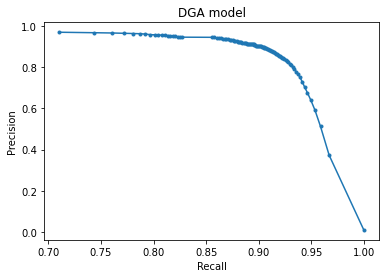

In [21]:
print("Evaluating binary model...")
model_eval_binary(model_binary, X_test, y_test, domain_test, type_test)

## Detection based on families model DGA

### Data processing and training model

In [22]:
print("Processing data for families model...")
train_generator, validation_generator, X_data, encoded_labels, steps_per_epoch, domains, labels_type, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff = data_preprocessing_families(df_families)

Processing data for families model...
nan
nan
nan
nan


In [24]:
# Takes long to run
print("Training families model...")
model_families = train_model_families(train_generator, steps_per_epoch)

Training families model...


### Evaluation of the families model

In [ ]:
print("Evaluating families model...")
model_eval_families(model_families, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff)

# Conclusion

In this work we show an example of detecting character based DGA algorithms with high Precision 0.9, Recall 0.9 and accuracy 0.95 of detecting many character DGA families. In future work, we plan to develop a word-based DGA model, that could tackle the limitation of character based DGA models. Our model is tested on AppShield - BlueField, an agentless system. By using AppShield we succeeded to detect DGA malwares before the malware connects with the command and control server.

# References
- https://data.netlab.360.com/dga/
- https://underdefense.com/guides/detecting-dga-domains-machine-learning-approach/
- https://developer.nvidia.com/networking/doca 
